In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [11]:
df = pd.read_csv("out_O2.csv")
T, nb_sim = np.shape(df)
nb_sim -= 1
print("Time horizon:", T)
print("Number of simulations:", nb_sim)

Time horizon: 36
Number of simulations: 100


In [12]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,4,0.004274,0.003933,0.003788,0.004035,0.004662,0.004129,0.003930,0.004137,0.003548,...,0.004030,0.004157,0.003598,0.004667,0.004862,0.004231,0.004818,0.004517,0.003545,0.003880
1,5,0.004275,0.003935,0.003790,0.004037,0.004660,0.004130,0.003932,0.004138,0.003551,...,0.004031,0.004158,0.003601,0.004665,0.004857,0.004231,0.004814,0.004516,0.003549,0.003882
2,6,0.004275,0.003936,0.003792,0.004038,0.004657,0.004131,0.003934,0.004139,0.003554,...,0.004032,0.004158,0.003604,0.004663,0.004854,0.004232,0.004811,0.004514,0.003551,0.003884
3,7,0.004275,0.003938,0.003794,0.004039,0.004656,0.004132,0.003935,0.004139,0.003556,...,0.004033,0.004159,0.003606,0.004661,0.004851,0.004232,0.004808,0.004513,0.003554,0.003886
4,8,0.004275,0.003939,0.003796,0.004040,0.004654,0.004132,0.003936,0.004140,0.003558,...,0.004034,0.004159,0.003608,0.004659,0.004848,0.004232,0.004805,0.004512,0.003556,0.003887


In [13]:
def plot_data(df):
    variables = [col for col in list(df.columns) if 'V' in col]
    
    plt.figure()
    for col in variables:
        plt.plot(df[col])
    plt.title('O2 evolution on {} simulations'.format(len(variables)))
    plt.ylabel('O2')
    plt.xlabel('time')
    plt.show()

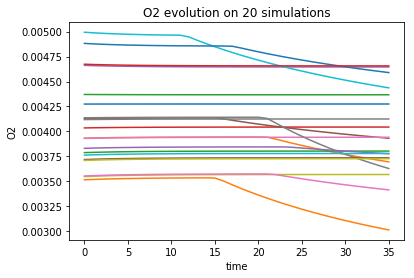

In [14]:
var = ['V' + str(i) for i in range(1, 21)]
plot_data(df[var])

### Parameters

In [15]:
# To compute X_data
len_X = 10  # len of X data to learn X prediction
tau = 5 # Time of prediction

# To compute Y:
thres_mean = 5e-5
X0 = 0.0042
thres_gal = 0.001

variables = [col for col in list(df.columns) if 'V' in col]

### Concatenation of X data and adding values of y

In [16]:
def process_var(df, variables):
    
    # Concatenation des x
    X = []
    trajec = []
    X_cummean = []

    for j in range(len(variables)):
        col = variables[j]
        X += list(df[col])
        # Trajec = the number of the trajectory
        trajec += [j for _ in range(len(df))]

        # CumMean of X (t-1 previous values)
        cummean = np.cumsum(df[col]) / np.array(range(1, len(df)+1))
        X_cummean += [df[col][0]] + list(cummean[:-1])

    data = pd.DataFrame({'X': X, 'trajec': trajec, 'X_cummean': X_cummean})
    
    # Compute Y
    data['X_diff'] = abs(data['X'] - data['X_cummean'])
    # The difference between X and the cummean is it below the threshold thres_mean ?
    data['Y1'] = data['X_diff'].apply(lambda x: 1 if x > thres_mean else 0)
    # The value of X is it below the general threshold thres_gal ?
    data['Y2'] = data['X'].apply(lambda x: 1 if abs(x - X0) > thres_gal else 0)

    # The incident happens if one of the two previous event happen
    data['Y'] = data['Y1'] + data['Y2']
    data['Y'] = data['Y'].apply(lambda x: 1 if x > 0 else 0)
    
    return data[['Y', 'X', 'trajec']]

In [17]:
data = process_var(df, variables)

In [18]:
data.head(T + 1)

,Y,X,trajec
0,0,0.004274,0
1,0,0.004275,0
2,0,0.004275,0
3,0,0.004275,0
4,0,0.004275,0
5,0,0.004275,0
6,0,0.004275,0
7,0,0.004275,0
8,0,0.004275,0
9,0,0.004275,0


### Treat X data

In [19]:
# Separate data x in windows of lenght len_X

# X_train: features from X data at each time t (X_train, and X_train2 are several version of features to compare them)
X_train = []
Y_train = []
X_train2 = []

nb_trajec = len(np.unique(data['trajec']))

for n in range(nb_trajec):
    for j in range(len_X, T - tau):
        i = n*T + j
        X_ = list(data['X'][i - len_X:i])  # Past
        X_train.append(X_)
        X_train2.append([np.mean(X_),
                         np.abs(np.mean(X_[:int(len_X/2)]) - np.mean(X_[int(len_X/2):])),
                         np.abs(data['X'][i] - np.mean(X_))])
        Y_train.append(data['Y'][i + tau])
        
X_train = np.array(X_train)
X_train2 = np.array(X_train2)
Y_train = np.array(Y_train)

In [20]:
nb_trajec, T

(100, 36)

#### Correlation coefficients

In [153]:
X = np.concatenate((X_train2, Y_train.reshape((len(Y_train), 1))), axis=1)
df_analyze = pd.DataFrame(X, columns=['X_mean', 'X_evol', 'X_diff_with_mean', 'Y'])

print("Correlation coefficients between the variables:")
df_analyze.corr()

Correlation coefficients between the variables:


,X_mean,X_evol,X_diff_with_mean,Y
X_mean,1.000000,-0.026664,-0.016296,-0.035105
X_evol,-0.026664,1.000000,0.951211,0.671375
X_diff_with_mean,-0.016296,0.951211,1.000000,0.753367
Y,-0.035105,0.671375,0.753367,1.000000


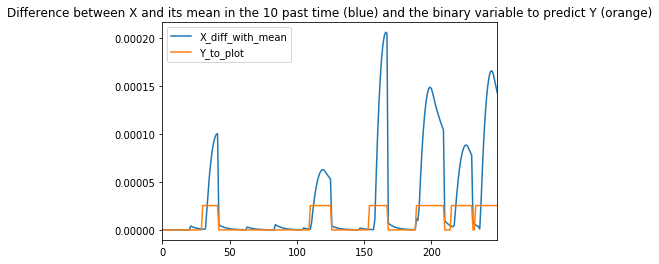

In [154]:
df_analyze['Y_to_plot'] = df_analyze['Y'] * df_analyze['X_diff_with_mean'].mean()

df_analyze[['X_diff_with_mean', 'Y_to_plot']][:250].plot()
plt.title('Difference between X and its mean in the {} past time (blue) and \
the binary variable to predict Y (orange)'.format(len_X))
plt.show()

La corrélation est assez marquante...

### Equilibrer les classes 

In [23]:
print(np.unique(Y_train))
len_Y1 = np.sum(Y_train)
len_Y0 = -np.sum([x - 1 for x in Y_train])
print("Y=1:", len_Y1, "data")
print("Y=0:", len_Y0, "data")

[0 1]
Y=1: 629 data
Y=0: 1471 data


In [31]:
X1 = X_train2[Y_train == 1]
X0 = X_train2[Y_train == 0]
indices = np.random.permutation(range(len(X0)))
new_X0 = X0[indices[:len_Y1]]
len(new_X0)

629

In [42]:
new_X = np.concatenate((new_X0, X1))
new_Y = [0 for _ in range(len(new_X0))] + [1 for _ in range(len(X1))]

In [43]:
np.shape(new_X)

(1258, 3)

### Classification

In [45]:
# Classification using a SVM (Support Vector Machine)
from sklearn import svm
lin_clf = svm.SVC()
lin_clf.fit(new_X, new_Y)

score = lin_clf.score(new_X, new_Y)
print("Score: {}%".format(round(score, 4)*100))

Score: 64.39%


In [46]:
Y_predict = lin_clf.predict(X_train2)

In [47]:
np.unique(Y_predict)

array([0, 1])

In [58]:
np.sum(Y_predict) / len(Y_predict)

0.35809523809523808

In [56]:
np.array(Y_predict[700:750]).T

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [57]:
np.array(new_Y[700:750]).T

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [55]:
np.array(data['X'][700:750]).T

array([ 0.00377813,  0.00377828,  0.00377841,  0.00377852,  0.00377861,
        0.00377869,  0.00377875,  0.0037788 ,  0.00377885,  0.00377888,
        0.00377892,  0.00377894,  0.00377896,  0.00377898,  0.003779  ,
        0.00377901,  0.00377902,  0.00377903,  0.00377904,  0.00377905,
        0.00433615,  0.00433587,  0.00433563,  0.00433543,  0.00433527,
        0.00433513,  0.00433502,  0.00433492,  0.00433484,  0.00433477,
        0.00433471,  0.00433467,  0.00433463,  0.00433459,  0.00433457,
        0.00433454,  0.00433452,  0.00433451,  0.00433449,  0.00433448,
        0.00433447,  0.00433446,  0.00433446,  0.00433445,  0.00433445,
        0.00433444,  0.00433444,  0.00433444,  0.00433444,  0.00433443])

In [160]:
np.unique(Y_train)

array([0, 1], dtype=int64)

In [60]:
## Linear SVM
lin_clf2 = svm.LinearSVC()
lin_clf2.fit(new_X, new_Y)

score = lin_clf2.score(new_X, new_Y)
print("Score: {}%".format(round(score, 4)*100))

Score: 59.38%


In [61]:
np.unique(lin_clf2.predict(new_X))

array([0, 1])

### Logistic regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
logreg = LogisticRegression()
logreg.fit(new_X, new_Y)
y_pred = logreg.predict(new_X)
print(np.sum(np.abs(new_Y - y_pred)) / len(new_Y))

0.382352941176


In [65]:
np.unique(y_pred)  # Et encore et toujours que des 0...

array([0, 1])